# 화물 이동 차량의 영상 분석: 화물 적재 유/무 판단(Classification)
## Data Preprocessing

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import os

In [3]:
# 이미지 파일 경로
path = "/Users/escortkwon/Downloads/2022-uou-ksoe-dt-02/"
train_path = path + "train/"
test_path = path + "test/"

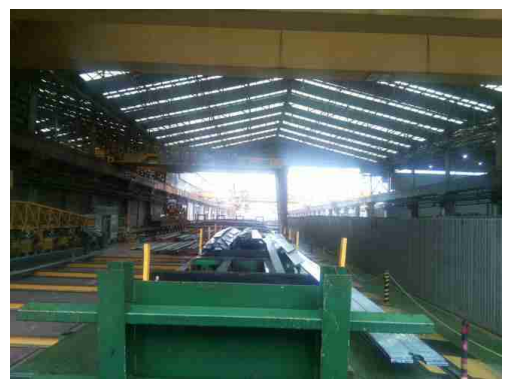

In [4]:
# Sample loaded images
img = cv2.imread(train_path + "1/loaded_T1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img)
plt.show()

### Applying filters to the image

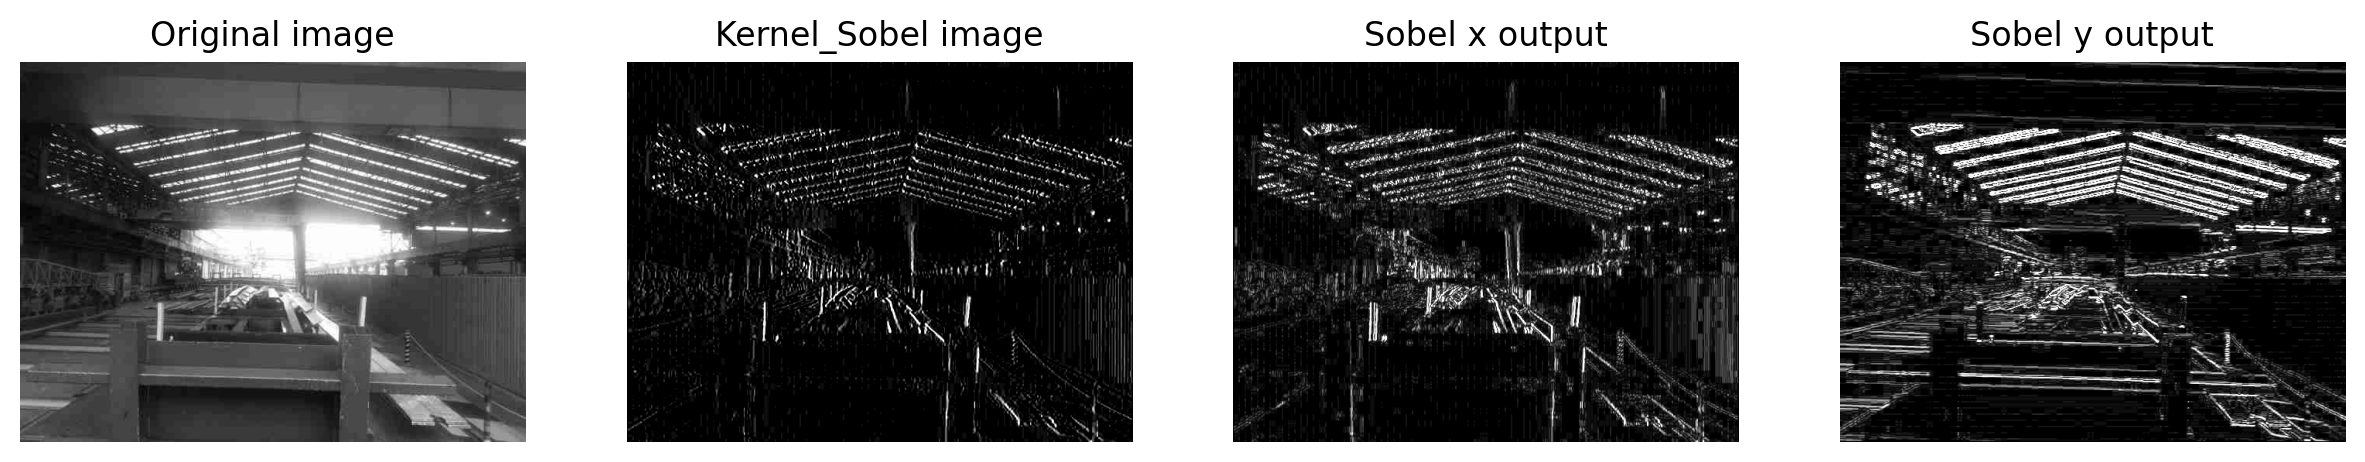

In [6]:
# Sobel filter
img = cv2.imread(train_path + "1/loaded_T1.png", cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
kernel = [[-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]]
kernel = np.array(kernel)
output = cv2.filter2D(img, -1, kernel)
output = cv2.convertScaleAbs(output)

output_sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
output_sobel_y = cv2.convertScaleAbs(output_sobel_y)
output_sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
output_sobel_x = cv2.convertScaleAbs(output_sobel_x)

fig = plt.figure()
rows = 1
cols = 4
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img, cmap='gray')
ax1.set_title('Original image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(output, cmap='gray')
ax2.set_title('Kernel_Sobel image')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(output_sobel_x, cmap='gray')
ax3.set_title('Sobel x output')
ax3.axis("off")

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(output_sobel_y, cmap='gray')
ax4.set_title('Sobel y output')
ax4.axis("off")
plt.rcParams['figure.figsize'] = [20, 4] #그림의 크기, (가로,세로)인치 단위
plt.rcParams['figure.dpi'] = 200
plt.show()

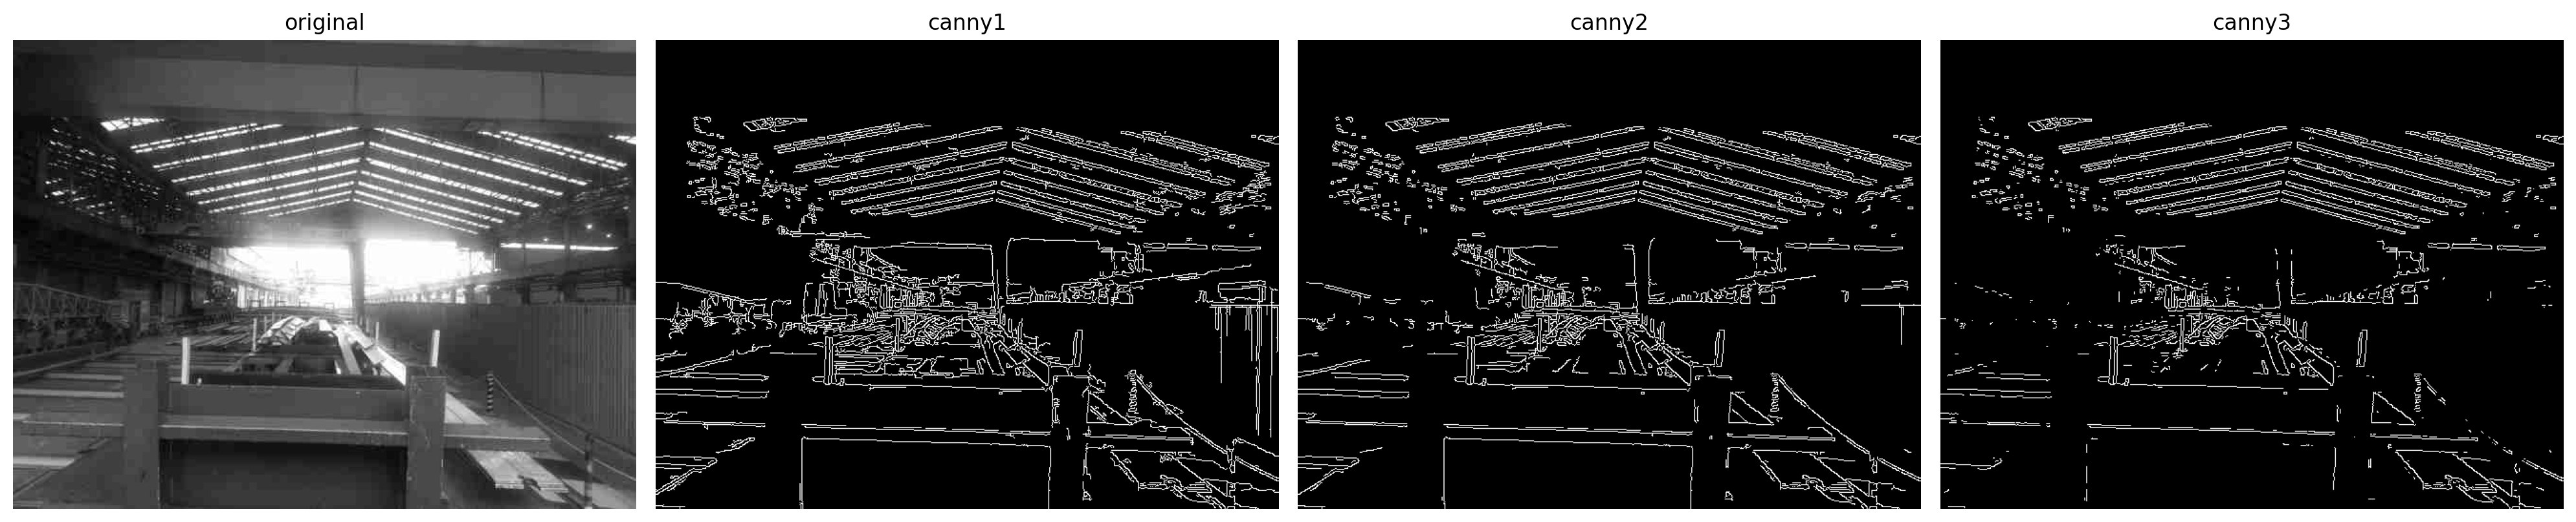

In [7]:
# Canny Filter
img = cv2.imread(train_path + "1/loaded_T1.png", cv2.IMREAD_GRAYSCALE)

canny1 = cv2.Canny(img, 50, 200)
canny2 = cv2.Canny(img, 100, 200)
canny3 = cv2.Canny(img, 170, 200)

titles = ['original', 'canny1', 'canny2', 'canny3']
images = [img, canny1, canny2, canny3]

plt.figure()
rows = 1
cols = 4
for i in range(cols):
    plt.subplot(rows, cols, i+1)
    # plt.imshow(images[i])
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
    
plt.tight_layout()
plt.show()

highThreshold: 51.0, lowThreshold: 5.1000000000000005


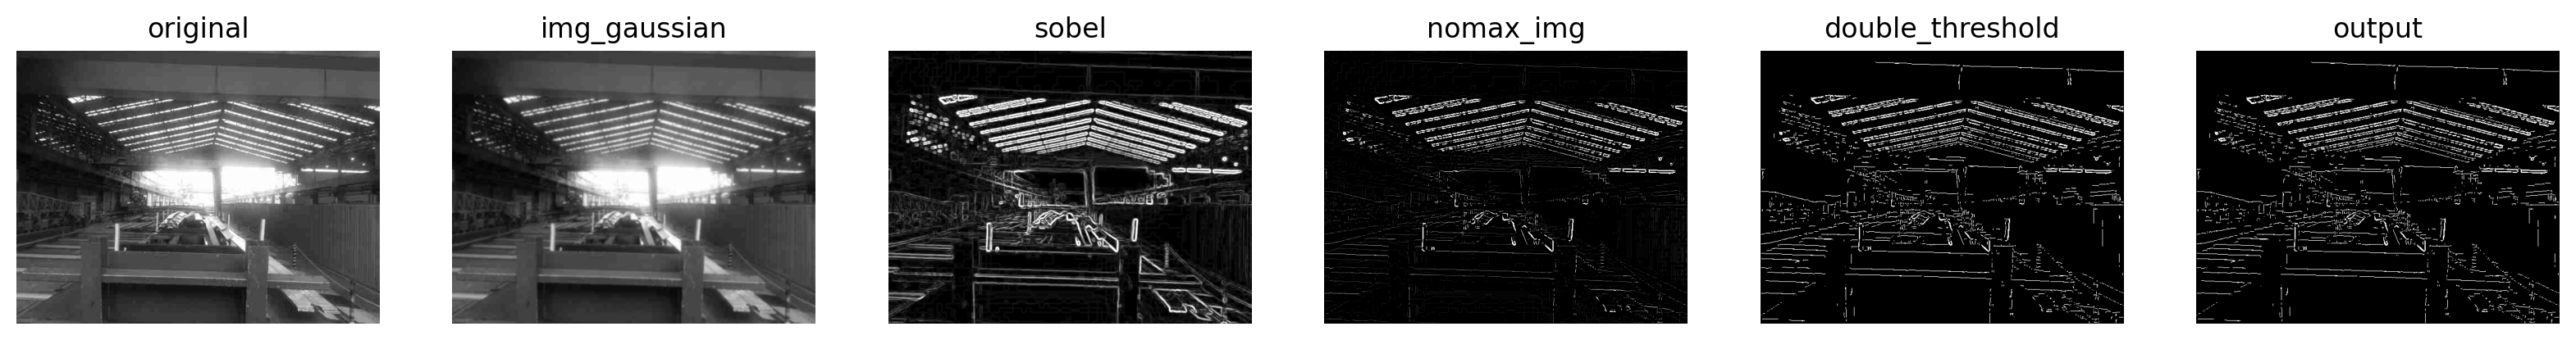

In [8]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    # print(g)
    return g

def sobel_gen(img):
    output_sobel_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    output_sobel_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    
    G = cv2.magnitude(output_sobel_x, output_sobel_y)
    sobel = np.clip(G, 0, 255).astype(np.uint8) # Magnitude의 발산을 막아주기 위해 필수
    directs = cv2.phase(output_sobel_x, output_sobel_y)
    return sobel, directs

    return (G, theta)
def non_max_suppression(img, D):
    M, N = img.shape[:2]
    # print(M,N)
    # print(D.shape)
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    # print("angle", angle)
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    # print(Z)
    return Z

def threshold(img, lowThresholdRatio=0.10, highThresholdRatio=0.20):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    print("highThreshold: {}, lowThreshold: {}".format(highThreshold, lowThreshold))
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(100)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    # print([strong_i, strong_j])
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

def hysteresis(img, weak=100, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

img = cv2.imread(train_path + "1/loaded_T1.png", cv2.IMREAD_GRAYSCALE)
g = gaussian_kernel(5)
img_gaussian = cv2.filter2D(img, -1, g)#-1은 img와 같은 타입의 값을 생성함
sobel, directs = sobel_gen(img_gaussian)
nomax_img = non_max_suppression(sobel, directs)
nomax_img = np.array(nomax_img, dtype=np.uint8)
double_threshold, weak, strong = threshold(nomax_img)
double_threshold = np.array(double_threshold, dtype=np.uint8)
output = hysteresis(double_threshold, weak=weak, strong=strong)

titles = ['original', 'img_gaussian', 'sobel', 'nomax_img', 'double_threshold', 'output']
images = [img, img_gaussian, sobel, nomax_img, double_threshold, output]

plt.figure()
rows = 1
cols = 6
for i in range(cols):
    plt.subplot(rows, cols, i+1)
    # plt.imshow(images[i])
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')
    plt.axis("off")
plt.rcParams['figure.figsize'] = [20, 4] #그림의 크기, (가로,세로)인치 단위
plt.rcParams['figure.dpi'] = 150
plt.show()

### ROI(Region of Interest) setting

(492, 654, 3)


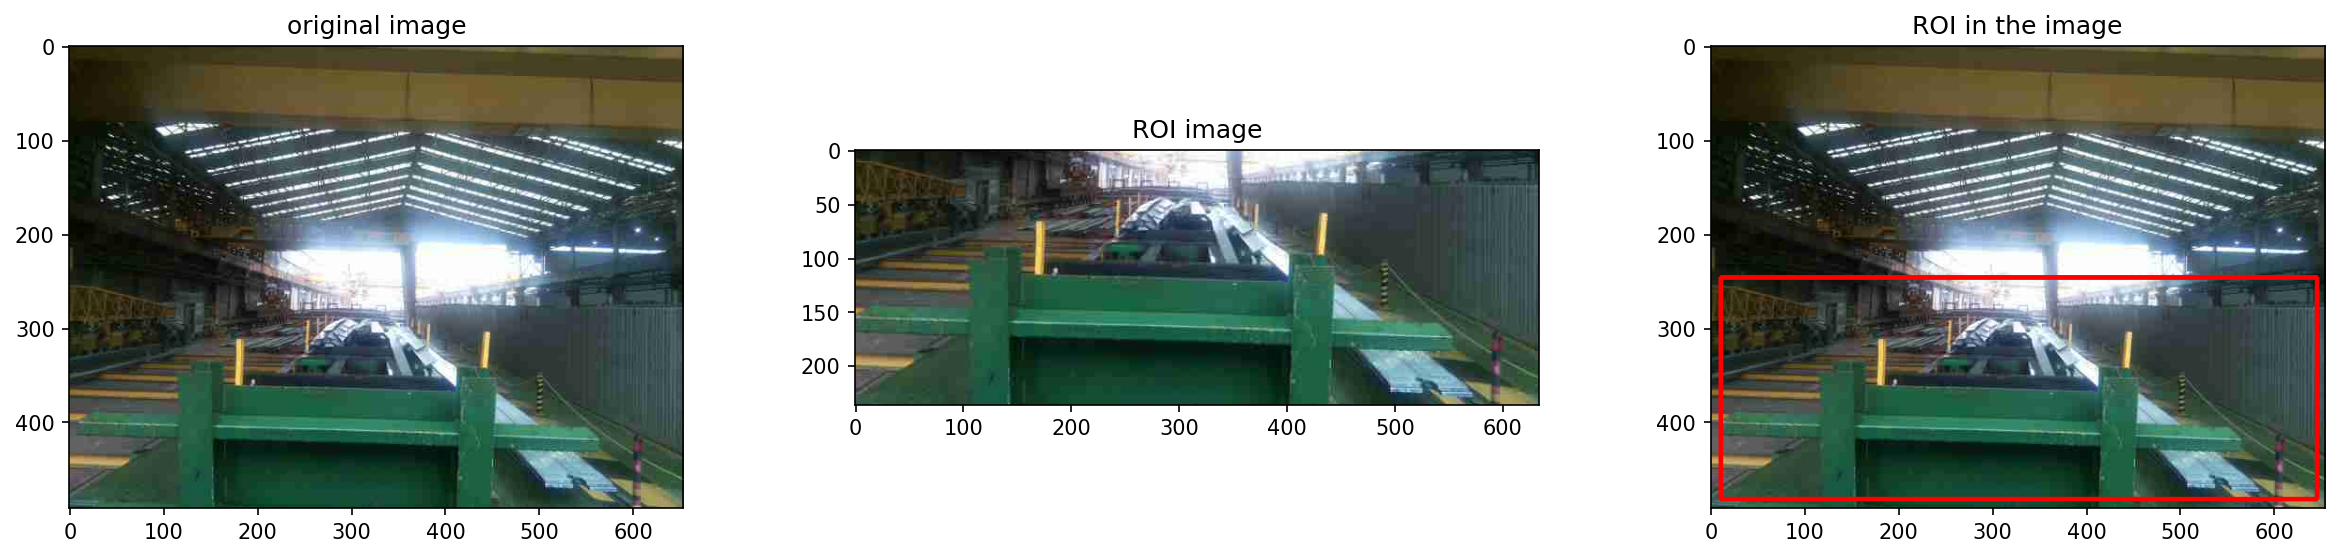

In [34]:
img = cv2.imread(train_path + "1/loaded_T1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

#ROI 영역 지정
start_x = int(img.shape[0] * (1/2))
start_y = 10
end_x = img.shape[0] - 10
end_y = img.shape[1] - 10

ROI = img[start_x:end_x, start_y:end_y]
img_roi = img.copy()
cv2.rectangle(img_roi, (start_y, start_x), (end_y, end_x), (255, 0, 0), 3)

titles = ['original image', 'ROI image', "ROI in the image"]
data = [img, ROI, img_roi]

plt.figure()
row = 1
cols = 3

for i in range(cols):
    plt.subplot(row, cols, i+1)
    plt.title(titles[i])
    plt.imshow(data[i])
plt.show()